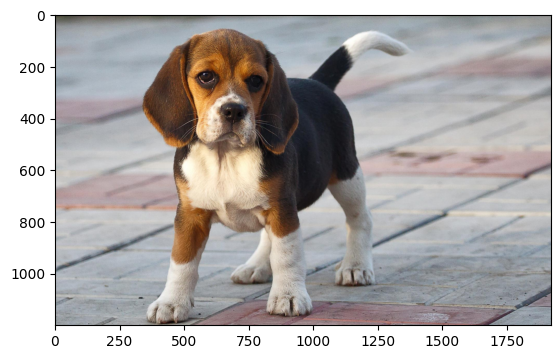

In [11]:
import torch
import numpy as np
import torchvision
import onnx
from torchvision.models import *
from torchvision.models.quantization import *
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image
import onnxruntime as ort
import cv2
import coremltools as ct
way="756ac8864b07aaf0393073b2741213ad.jpeg"
img = cv2.imread(way)
plt.imshow(plt.imread(way))#рисование картинки

In [2]:
def img2tensor(img: np.ndarray, mean: list, std: list, size: int = 224) -> torch.Tensor:
    t = cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA)
    t = torch.from_numpy(t.astype(np.float32)/ 255.0) # 0..255->0..1
    t = t.permute(2,0,1) # hwc -> chw
    _m = torch.FloatTensor(mean).unsqueeze(1).unsqueeze(1) #cx1x1
    _s = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
    t = (t - _m) / (_s + 1E-7)
    return t
tensor_img1 = img2tensor(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).unsqueeze(0)
print(tensor_img1.shape)

torch.Size([1, 3, 224, 224])


In [3]:
model = torchvision.models.mnasnet1_0(weights=MNASNet1_0_Weights.IMAGENET1K_V1)
model.eval()

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [4]:
with torch.no_grad():tensor_img1_out = model(tensor_img1)
print(tensor_img1_out)

tensor([[-5.1671e+00, -4.4429e+00, -5.0118e+00, -6.7896e+00, -3.0304e+00,
         -5.7711e+00, -5.9942e+00,  2.4253e+00,  1.6282e-01, -7.6646e+00,
         -5.9870e+00, -2.2824e+00, -6.1410e+00, -2.7040e+00, -1.1709e+00,
         -3.7854e+00, -4.4281e+00,  7.0701e-01,  1.4361e+00, -4.7738e+00,
         -3.9688e+00, -9.4174e-02,  2.0984e-01,  2.7295e+00, -3.1619e+00,
         -5.3936e+00, -4.7542e+00, -4.3312e+00, -4.5505e+00, -4.3963e+00,
         -3.7362e+00,  1.6815e+00,  5.1558e-01, -2.0941e+00, -3.3280e+00,
         -3.0773e+00, -1.9707e+00, -3.0171e-01, -2.6396e+00, -1.6506e+00,
          5.2646e-01, -2.3694e+00,  4.8085e+00,  9.4972e-01, -3.3562e+00,
         -3.6730e+00, -6.9996e-01, -2.1735e+00, -2.5035e-01, -7.5522e+00,
         -9.1443e+00, -1.3838e+00, -9.1368e-01, -2.8720e+00, -2.6575e+00,
         -1.4722e+00, -3.3574e+00, -6.0103e+00, -1.1673e+00, -1.6593e+00,
         -5.0355e-01,  3.7905e-01, -3.2302e+00,  2.2275e+00, -3.3842e+00,
         -7.8712e-01, -4.9176e+00, -4.

In [5]:
out_probs = torch.nn.functional.softmax(tensor_img1_out[0], dim = 0)
!curl https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -o imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:categories = [s.strip() for s in f.readlines()]
prob, category_id = torch.topk(out_probs, 5)
for i in range(prob.size(0)):
    print(categories[category_id[i]], prob[i].item())

beagle 0.7064034938812256
Walker hound 0.2001674920320511
bluetick 0.04484479874372482
basset 0.04192674532532692
English foxhound 0.0025612337049096823


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10472  100 10472    0     0  13232      0 --:--:-- --:--:-- --:--:-- 13255


In [6]:
dummy_input = torch.randn(1, 3, 224, 224)
input_names = [ "img_input" ]
output_names = [ "output1" ]
torch.onnx.export(model, dummy_input, "mnasnet1_0.onnx", verbose=True, input_names=input_names, output_names=output_names)
# Load the ONNX model
model_onnx = onnx.load("mnasnet1_0.onnx")
onnx.checker.check_model(model_onnx)
#print(onnx.helper.printable_graph(model_onnx.graph))

In [7]:
ort_session = ort.InferenceSession("mnasnet1_0.onnx",providers=['CPUExecutionProvider'])
model_input_name = ort_session.get_inputs()[0].name
model_output_name = ort_session.get_outputs()[0].name
x = tensor_img1.numpy()
out = ort_session.run(
    [model_output_name],
    {model_input_name: x}
)
print(out[0])
'''
python -m pip install -U pip
pip uninstall -y onnx onnxruntime onnxruntime-gpu onnxruntime-silicon
pip uninstall -y onnxruntime-extensions <<<<< This i didn't have it, but i tried.
pip install onnx==1.14.0 onnxruntime==1.15.0
'''

[[-5.16704416e+00 -4.44292307e+00 -5.01175499e+00 -6.78961658e+00
  -3.03044176e+00 -5.77106619e+00 -5.99420357e+00  2.42529082e+00
   1.62826538e-01 -7.66464424e+00 -5.98697996e+00 -2.28237152e+00
  -6.14099121e+00 -2.70402527e+00 -1.17086720e+00 -3.78541374e+00
  -4.42811203e+00  7.07013905e-01  1.43613601e+00 -4.77375698e+00
  -3.96878242e+00 -9.41742659e-02  2.09834993e-01  2.72948337e+00
  -3.16192245e+00 -5.39364815e+00 -4.75424767e+00 -4.33117628e+00
  -4.55054998e+00 -4.39625597e+00 -3.73617816e+00  1.68147850e+00
   5.15578449e-01 -2.09414411e+00 -3.32799935e+00 -3.07734156e+00
  -1.97065008e+00 -3.01711708e-01 -2.63957572e+00 -1.65061843e+00
   5.26457846e-01 -2.36939192e+00  4.80852461e+00  9.49714959e-01
  -3.35615826e+00 -3.67303896e+00 -6.99958086e-01 -2.17348862e+00
  -2.50344753e-01 -7.55220366e+00 -9.14426613e+00 -1.38383853e+00
  -9.13677454e-01 -2.87201142e+00 -2.65752029e+00 -1.47217441e+00
  -3.35742068e+00 -6.01027870e+00 -1.16732061e+00 -1.65929413e+00
  -5.03548

"\npython -m pip install -U pip\npip uninstall -y onnx onnxruntime onnxruntime-gpu onnxruntime-silicon\npip uninstall -y onnxruntime-extensions <<<<< This i didn't have it, but i tried.\npip install onnx==1.14.0 onnxruntime==1.15.0\n"

In [8]:
np.linalg.norm(out[0]-tensor_img1_out.numpy())

8.8356275e-05

In [9]:
traced_model = torch.jit.trace(model, dummy_input)

In [10]:
#заработает, если понизить версию библиотек 
ml_model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=dummy_input.shape)]
 )


Running MIL default pipeline:   0%|                                                        | 0/66 [00:00<?, ? passes/s]C:\Users\pavel\anaconda3\lib\site-packages\coremltools\converters\mil\mil\passes\defs\preprocess.py:239: UserWarning: Input, 'x.1', of the source model, has been renamed to 'x_1' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|████████████████████████████████████| 12/12 [00:00<00:00, 348.33 passes/s]


RuntimeError: BlobWriter not loaded

In [ ]:
ml_model.save("mnasnet1_0.mlpackage")